<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# Downloading and Training a Model using the Radiant MLHub Python Client

In this notebook, we will run through the process of using the Radiant MLHub Python Client to download a training dataset from Radiant MLHub and training a very basic cloud detection model. The purpose of this notebook isn't to show how to develop a good model but instead to show how with just a relatively little amount of code we can have a (basic) model ready for inferencing

## Dependencies

This notebook utilizes the [`radiant-mlhub` Python client](https://pypi.org/project/radiant-mlhub/) for interacting with the API. If you are running this notebooks using Binder, then this dependency has already been installed. If you are running this notebook locally, you will need to install this yourself. We will also be using the `torch` library for the model development, `tqdm`, `rasterio`, and `matplotlib` for various utility functions.

See the official [`radiant-mlhub` docs](https://radiant-mlhub.readthedocs.io/) for more documentation of the full functionality of that library.

In [ ]:
!pip3 install radiant-mlhub==0.5.0 torch tqdm rasterio matplotlib

Authentication
===
## Create an API Key
Access to the Radiant MLHub API requires an API key. To get your API key, go to [mlhub.earth](https://mlhub.earth/profile). If you have not used Radiant MLHub before, you will need to sign up and create a new account. Otherwise, sign in. In the **Settings and Profile** section, you'll be able to create API key(s), which you will need. Do not share your API key with others: your usage may be limited and sharing your API key is a security risk.

## Configure the Client
Once you have your API key, you need to configure the `radiant_mlhub` library to use that key. There are a number of ways to configure this (see the [Authentication docs](https://radiant-mlhub.readthedocs.io/en/latest/authentication.html) for details).

For these examples, we will set the `MLHUB_API_KEY` environment variable. Run the cell below to save your API key as an environment variable that the client library will recognize.

If you are running this notebook locally and have configured a profile as described in the [Authentication docs](https://radiant-mlhub.readthedocs.io/en/latest/authentication.html), then you do not need to execute this cell.

In [4]:
import os
os.environ['MLHUB_API_KEY'] = '38ebb2bb5603737e87cd2c258b19b5035dd056ac87bdd6792f45872ab0bc24ae'

Defining Training Data AoI
===

I've gone ahead and preselected an AoI which we will use for filtering our training data. We will download any of the training data which falls within this small region around Kilimanjaro National Park in Tanzania. You can visualize the area this AoI covers at this [GitHub Gist link](https://gist.github.com/kbgg/7ad5b5a2e4eee3f86008409deae6a311).

In [5]:
aoi = {
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          36.990966796875,
          -3.4640741915530184
        ],
        [
          37.5457763671875,
          -3.4640741915530184
        ],
        [
          37.5457763671875,
          -2.9156109787373894
        ],
        [
          36.990966796875,
          -2.9156109787373894
        ],
        [
          36.990966796875,
          -3.4640741915530184
        ]
      ]
    ]
  }
}

Downloading Dataset Assets
===
After browsing through the [datasets page](https://mlhub.earth/datasets), we found the cloud cover dataset that we wish to train a model with. This dataset has the ID `ref_cloud_cover_detection_challenge_v1` and has four collections. There are two test/train collections for cloud cover labels and two test/train collections for Sentinel-2 source imagery.

For this notebook we are just keeping it simple and only downloading a small region of data covered by the AoI which works out to around 83 chips. In the next cell, I selected 5 of these 83 chips which provides a good balance of cloudy / non-cloudy pixels for training.

You might also notice that we are downloading only from the `test` collection. Typically in datasets hosted on Radiant MLHub, we don't split the datasets into train/test splits but since this dataset was first developed for a competition with a predefined train and test split we kept that convention when ingesting the dataset into Radiant MLHub. Practically there is no difference between using train or test chips here for training.

In [6]:
from radiant_mlhub import Dataset
dataset = Dataset.fetch('ref_cloud_cover_detection_challenge_v1')
my_filter = dict(
    ref_cloud_cover_detection_challenge_v1_test_labels=['labels'],
    ref_cloud_cover_detection_challenge_v1_test_source=['B02', 'B03', 'B04', 'B08'],
)
dataset.download(intersects=aoi, collection_filter=my_filter)

unarchive ref_cloud_cover_detection_challenge_v1.tar.gz: 100%|██████████| 90922/90922 [00:01<00:00, 52455.19it/s]


KeyboardInterrupt: 

Training Data Loader
===

Once the previous cell completes, all of the files matching the filters are downloaded locally into the same directory that this notebook is running within. This cell then locates all of the label and source rasters and loads the pixel samples into a custom PyTorch DataLoader. On the third to last line, we select the first five chips which provide a good balance of cloudy and non-cloudy pixels.

In [3]:
import math
import glob
import os
import rasterio
import torch
import numpy as np
from functools import lru_cache
from urllib.parse import urljoin
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

batch_size = 64

def label_item_stac_files(labels_directory):
    label_stac_files = []
    files = glob.glob(f'{labels_directory}/**/*.json')
    
    for fname in files:
        if os.path.exists(os.path.join(Path(fname).parent, 'labels.tif')):
            label_stac_files.append(fname)
            
    return label_stac_files
    
def load_raster(fname):
    with rasterio.open(fname) as src:
        return src.read()[0].flatten(), src.profile

@lru_cache(maxsize=32)
def get_item_data(item_stac, assets=['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif']):
    labels, profile = load_raster(os.path.join(Path(item_stac).parent, 'labels.tif'))
    
    source_stac = item_stac.replace('labels', 'source')
    source_samples = []
    for asset in assets:
        source, profile = load_raster(os.path.join(Path(source_stac).parent, asset))
        source_samples.append(source)
        
    source_samples = np.array(source_samples).swapaxes(0, 1)
    
    return source_samples, labels, profile

class ExampleDataset(Dataset):
    def __init__(self, label_stacs, label_dimension=(256,256)):
        self.label_stacs = label_stacs
        self.label_dimension = label_dimension       
        self.cached_item = [None, None]

    def __len__(self):
        return len(self.label_stacs) * self.label_dimension[0] * self.label_dimension[1]

    def __getitem__(self, idx):
        item_idx = math.floor(idx / (self.label_dimension[0] * self.label_dimension[1]))
        item_stac = self.label_stacs[item_idx]
            
        source_samples, labels, profile = get_item_data(item_stac)
            
        sample_index = idx - (item_idx * (self.label_dimension[0] * self.label_dimension[1]))
        
        return torch.FloatTensor(source_samples[sample_index].tolist()), torch.FloatTensor([int(labels[sample_index])])
    
train_label_items = label_item_stac_files('ref_cloud_cover_detection_challenge_v1/ref_cloud_cover_detection_challenge_v1_test_labels')[:5]
training_data = ExampleDataset(label_stacs=list(train_label_items))
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

Visualizing Training Data Class Balance
===

Here we calculate the number of cloudy and non-cloudy pixels in our training dataset. We can see that there are around 40% more cloudy pixels but we'll go through the rest of the training process and see how the model performance with this class distribution.

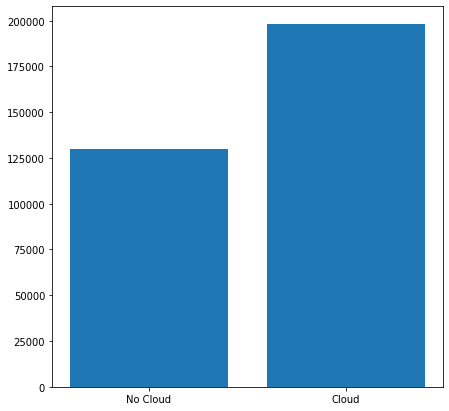

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(7,7))

samples = []

for batch, (X, y) in enumerate(train_dataloader):
    samples.extend(y.reshape(-1).detach().numpy().round().astype(np.uint16))
    
unique, counts = np.unique(samples, return_counts=True)
ax.bar(['No Cloud', 'Cloud'], counts)
plt.show()

Defining Model Architecture
===

For this model we will classify each pixel individually. The four inputs are the `B02`, `B03`, `B04`, and `B08` Sentinel-2 pixel values and the output is either a `0` for not cloudy or `1` for cloudy.

In [5]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.hid1 = nn.Linear(4, 8)
        self.hid2 = nn.Linear(8, 8)
        self.oupt = nn.Linear(8, 1)

        nn.init.xavier_uniform_(self.hid1.weight)
        nn.init.zeros_(self.hid1.bias)
        nn.init.xavier_uniform_(self.hid2.weight)
        nn.init.zeros_(self.hid2.bias)
        nn.init.xavier_uniform_(self.oupt.weight)
        nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = torch.tanh(self.hid1(x)) 
        x = torch.tanh(self.hid2(x))
        x = torch.sigmoid(self.oupt(x))
        
        return x

Training the Model
===

In [6]:
from tqdm import tqdm

learning_rate = 0.001
epochs = 5

def train_loop(dataloader, model, loss_fn, optimizer, epoch=1, total_epochs=5):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % batch_size * 100 == 0:
            current_loss = loss.item()
        
        t.set_description_str(f'Epoch: {epoch}/{total_epochs}; Current Loss: {current_loss:0.2f}')
        t.update(batch_size)
        
model = NeuralNetwork()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

with tqdm(total=len(train_dataloader.dataset) * epochs) as t:
    for e in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer, epoch=e+1, total_epochs=epochs)

Epoch: 5/5; Current Loss: 0.23: 100%|██████████| 1638400/1638400 [01:01<00:00, 26854.66it/s]


Visually Validating Model Performance
===

After the model has been trained we can run an inference on a chip which the model has not been trained on and quickly validate the performance of the model visually. Here we can see that after being trained on even just 5 chips the model has some reasonable performance. Of course, if we were training this model for a production environment then we would train on a much larger subset or even the whole dataset as well as calculate accuracy metrics but for the purposes of this notebook this is good enough.

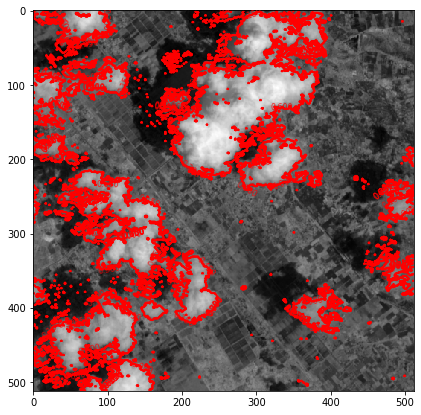

In [11]:
from rasterio.plot import show

def inference(item_stac):
    fig, ax = plt.subplots(1, figsize=(7,7))
    source_samples, labels, profile = get_item_data(item_stac)
    predictions = model(torch.FloatTensor(source_samples.tolist()))
    
    predictions = np.flip(predictions.reshape(-1).detach().numpy().round().reshape(512,512), 0).astype(np.uint16)
    source_samples = source_samples.reshape(512, 512, 4).swapaxes(2, 0).swapaxes(2,1)
    
    show(source_samples[3], ax=ax, cmap='Greys_r', interpolation='none')
    show(predictions, ax=ax, contour=True)
        
label_files = list(set(label_item_stac_files('ref_cloud_cover_detection_challenge_v1/ref_cloud_cover_detection_challenge_v1_test_labels')) - set(train_label_items))
inference(label_files[3])